In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import interactive
from matplotlib import colors
import seaborn as sns
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
from math import exp
import matplotlib.ticker as ticker

In [2]:
AVD_data = pd.read_csv('raw_data/Adventdalen_Hour.dat', 
	skiprows = [0,2,3],index_col = 0,parse_dates = True, na_values = 'NAN', header = 0 ,
	names = ['TIMESTAMP','RECORD','ID','T2m_PT1000_Max','T2m_PT1000_Min','T2m_PT1000_Avg',
	'T10m_PT1000_Max','T10m_PT1000_Min','T10m_PT1000_Avg',
	'T2m_Rotron_Max','T2m_Rotron_Min','T2m_Rotron_Avg',
	'LF2m_Rotron_Max','LF2m_Rotron_Avg','T10m_Rotron_Max',
	'T10m_Rotron_Min', 'T10m_Rotron_Avg', 'LF10m_Rotron_Max',
	'LF10m_Rotron_Avg','p_mbar','ff2m_mps_Max','ff2m_10min',
	'ff2m_mps_avg', 'dd2m', 'ff10m_sek_Max', 'ff10m_10min',
	'ff10m_mps_Avg','dd10m','Batt_V_Min'])

# Import data from radiation measurements Adventdalen 
AVD_rad_all = pd.read_csv('raw_data/Adventdalen_New_Fem_minutt.dat', 
	skiprows = [0,2,3],index_col = 0, parse_dates = True, na_values = 'NAN',header = 0,
	names = ['TIMESTAMP','RECORD','SWin_Wpm2','LWin_Wpm2','SWout_Wpm2','LWout_Wpm2','CNR1_temp_gr_C_Avg'])

# Radiaton data is available in 5min steps, create hourly mean values of the radiation components. 
# shift(1) - shift the whole dataset by one timestep so that a value at each timestep is the mean of the previous hour
AVD_rad_data = pd.DataFrame.from_dict({
	'SWin_Wpm2':AVD_rad_all['SWin_Wpm2'].resample('H').mean().shift(1), #opp..upward looking instrument measuring SW down
	'SWout_Wpm2': AVD_rad_all['SWout_Wpm2'].resample('H').mean().shift(1), #ned..downward looking instrument measuring SW up
	'LWin_Wpm2': AVD_rad_all['LWin_Wpm2'].resample('H').mean().shift(1),
	'LWout_Wpm2': AVD_rad_all['LWout_Wpm2'].resample('H').mean().shift(1)})
# Import data from AWS Gruvefjellet (GF)
GF_data = pd.read_csv('raw_data/Gruvefjellet_Res_data.dat', 
	skiprows = [0,2,3], index_col = 0,parse_dates = True, na_values = 'NAN', header = 0 ,
	names = ['TIMESTAMP','RECORD','ID','T10cm_minutt_Max','T10cm_minutt_Min','T10cm_minutt_Avg',
	'T1m_minutt_Max','T1m_minutt_Min','T1m_minutt_Avg',
	'T3m_minutt_Max','T3m_minutt_Min','T3m_minutt_Avg',
	'LF_minutt_Max','LF_minutt_Avg','p_mbar','ff_mps_Max','ff_10min',
	'ff_mps_avg', 'dd','NB_time','SD_m','SD_kval','TSS','T_soil_1m',
	'T_soil_2m','T_soil_3m','T_soil_4m','T_soil_5m','T_soil_6m',
	'R_surf_ohm','R_1m_ohm', 'R_2m_ohm', 'R_3m_ohm', 'R_4m_ohm',
	'R_5m_ohm', 'R_6m_ohm', 'Batt_V_Min'])

# Import ERA5 precipitation data
ERA5_all = pd.read_csv('data/ERA5_GF.txt', index_col = 0, parse_dates = True,
	na_values = 'NaN', header = 0, names = ['TIMESTAMP', 'HS', 'RR', 'RRmm',
	'T2m', 'ptype'])
# eklima precipitation data
eklima_LFH_RR_all = pd.read_csv('data/LFH_RR_ts.txt', index_col=0,parse_dates = True,
na_values='NaN',header=0, names= ['RR','ff'])
eklima_AVD_RR_all = pd.read_csv('data/AVD_RR_ts.txt', index_col=0,parse_dates = True,
na_values='NaN',header=0, names= ['RR','ff'])
eklima_LFH_T_all = pd.read_csv('data/LFH_T_ts.txt', index_col=0,parse_dates = True,
na_values='NaN',header=0, names= ['T'])
eklima_AVD_T_all = pd.read_csv('data/AVD_T_ts.txt', index_col=0,parse_dates = True,
na_values='NaN',header=0, names= ['T'])

In [11]:
GF_data = GF_data['2016-12-01 00:00:00':'2017-01-01 23:00:00']			 	
AVD_rad_data = AVD_rad_data['2016-08-01 00:00:00':'2017-04-30 23:00:00'] 
AVD_data = AVD_data['2016-12-01 00:00:00':'2017-01-01 23:00:00']
eklima_LFH_RR = eklima_LFH_RR_all['2016-08-01 06:00:00':'2017-04-30 23:00:00']
eklima_AVD_RR = eklima_AVD_RR_all['2016-08-01 06:00:00':'2017-04-30 23:00:00']
eklima_LFH_T = eklima_LFH_T_all['2016-08-01 00:00:00':'2017-04-30 23:00:00']
eklima_AVD_T = eklima_AVD_T_all['2016-08-01 00:00:00':'2017-04-30 23:00:00']
ERA5 = ERA5_all['2016-08-01 06:00:00':'2017-04-30 23:00:00']

In [4]:
Tdiff_GFAVD_3m2mRot = GF_data.T3m_minutt_Avg - AVD_data.T2m_Rotron_Avg
Tdiff_GFAVD_3m2mPT = GF_data.T3m_minutt_Avg - AVD_data.T2m_PT1000_Avg
Tgrad_GFAVD_3m2mRot = Tdiff_GFAVD_3m2mRot/(464-15)*100
Tgrad_GFAVD_3m2mPT = Tdiff_GFAVD_3m2mPT/(464-15)*100

RHdiff_GFAVD_3m2mRot = GF_data.LF_minutt_Avg - AVD_data.LF2m_Rotron_Avg
RHgrad_GFAVD_3m2mRot = RHdiff_GFAVD_3m2mRot/(464-15)*100

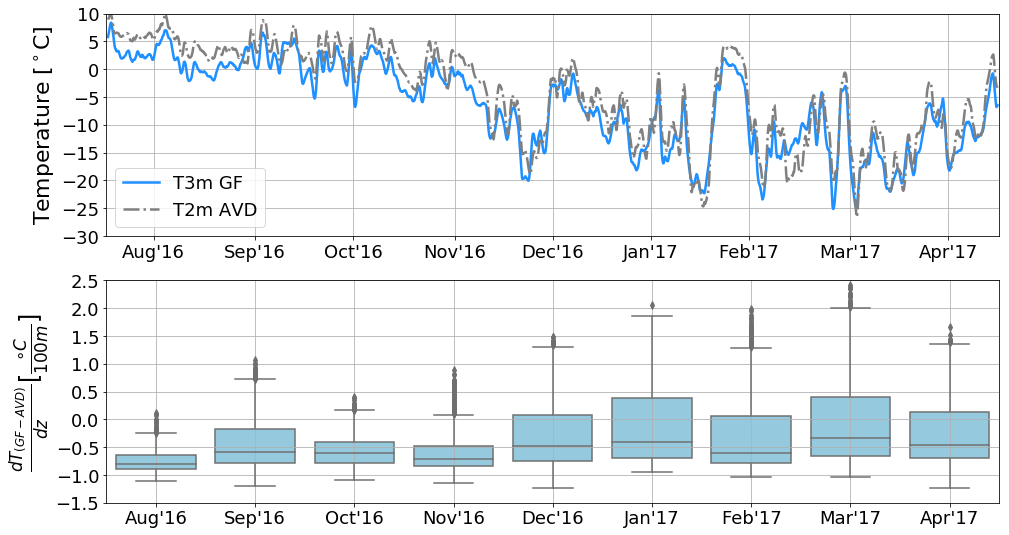

In [5]:
f9, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (16,9))
maxGF = max(GF_data.T3m_minutt_Avg)
date_maxGF = GF_data.T3m_minutt_Avg.idxmax()
date_minGF = GF_data.T3m_minutt_Avg.idxmin()
# print(date_maxGF,date_minGF)
maxAVD = max(AVD_data.T2m_PT1000_Avg)
date_maxAVD = AVD_data.T2m_PT1000_Avg.idxmax()
date_minAVD = AVD_data.T2m_PT1000_Avg.idxmin()
# print(date_maxAVD,date_minAVD)


dTind = GF_data.index
xticks=[]
dates = ['2016-08-15 12:00:00','2016-09-15 12:00:00','2016-10-15 12:00:00','2016-11-15 12:00:00','2016-12-15 12:00:00',
        '2017-01-14 12:00:00','2017-02-13 12:00:00','2017-03-16 12:00:00','2017-04-15 12:00:00',]
for counter, value in enumerate(dTind):
    if str(value) in dates:
        xticks.append(counter)

ax1.grid()
data = pd.DataFrame.from_records({"GF":GF_data.T3m_minutt_Avg.tolist(),'AVD':AVD_data.T2m_PT1000_Avg.tolist()})
ax1.plot(data.index, data.GF.rolling(24,center=True).mean(),color="#1E90FF",linestyle='-',linewidth=2.5, label = "T3m GF")
ax1.plot(data.index, data.AVD.rolling(24,center=True).mean(),color ="#808080",linestyle='-.', linewidth=2.5, label = "T2m AVD")
ax1.set_ylabel("Temperature [$^\circ$C]",fontsize =22)
ax1.set_ylim((-30,10))
ax1.yaxis.set_major_locator(plt.MaxNLocator(10))
ax1.set_yticks(np.arange(-30,11,5))
ax1.set_xlim((0,len(data.index)))
# ax1.tick_params(axis='x',which='minor', bottom = False)
# ax1.xaxis.set_minor_locator(AutoMinorLocator)
ax1.set_xticks(ticks=xticks)
# ax1.set_xticklabels(['2016-08-01','2016-09-01','2016-10-01','2016-11-01','2016-12-01',
#         '2017-01-01','2017-02-01','2017-03-01','2017-04-01'])
ax1.set_xticklabels(['Aug\'16','Sep\'16','Oct\'16','Nov\'16','Dec\'16',
        'Jan\'17','Feb\'17','Mar\'17','Apr\'17'])
ax1.tick_params(labelsize=18)
ax1.legend(fontsize=18)

    
sns.boxplot(Tgrad_GFAVD_3m2mRot.index.strftime("%b\'%y"),Tgrad_GFAVD_3m2mRot,ax=ax2,
 color='skyblue', saturation=0.75)
ax2.set_ylabel(r'$\frac{dT_{(GF-AVD)}}{dz} [\frac{\circ C}{100 m}]$', fontsize=24)
ax2.tick_params(labelsize=18)
ax2.set_ylim([-1.5,2.5])
ax2.yaxis.set_major_locator(plt.MaxNLocator(9))
# ax2.set_yticklabels([-1.5,-1.0,-0.5,0,0.5,1,1.5,2,2.5])
ax2.grid()

# data = pd.DataFrame()
# data['Date']=Tgrad_GFAVD_3m2mRot.index.date
# data['Time']=Tgrad_GFAVD_3m2mRot.index.strftime("%H")
# data['Tgrad']=Tgrad_GFAVD_3m2mRot.values
# data["datenum"]=mdates.date2num(data["Date"])

# C = data.pivot(index='Time', columns='Date', values='Tgrad')
# # print(C.head())
# # fig, ax = plt.subplots(figsize = (16,9))
# cmap = colors.ListedColormap(["#1F28A2","#2C329F","#363A9E","#3E429E","#464A9F","#4E51A2","#5659A4","#5E61A7","#6668AB","#6F70AE","#7779B2","#8081B7","#898ABB","#9394C0","#9D9EC6","#A7A8CB","#B3B4D1","#C0C0D8","#CECFDF","#E1E1E9","#E9DFDF","#E1CBCB","#DABBBB","#D3ADAD","#CDA0A0","#C79494","#C18989","#BB7F7F","#B67475","#B06B6B","#AB6162","#A55858","#A04F4F","#9B4647","#953D3E","#903435","#8B2B2C","#862122","#811617","#7C0607"])

# pl = ax3.imshow(C,cmap=cmap,aspect = 'auto',
#                extent=[data["datenum"].iloc[0],data["datenum"].iloc[-1],data["Time"].iloc[0],data["Time"].iloc[-1]],
#                origin = "lower")
# ax3.set_yticks(data["Time"])
# ax3.xaxis_date()
# ax3.xaxis.set_major_formatter(mdates.DateFormatter("%b\'%y"))
# ax3.tick_params(labelsize=18)
# fig.autofmt_xdate()
# plt.colorbar(pl)

plt.savefig('./figures/timel_T3mGF_T2mAVD_with_boxpl_Tgrad.png')
plt.savefig('./figures/timel_T3mGF_T2mAVD_with_boxpl_Tgrad.eps')

# print('GF',GF_data.T3m_minutt_Avg.describe())
# print('AVD',AVD_data.T2m_PT1000_Avg.describe())


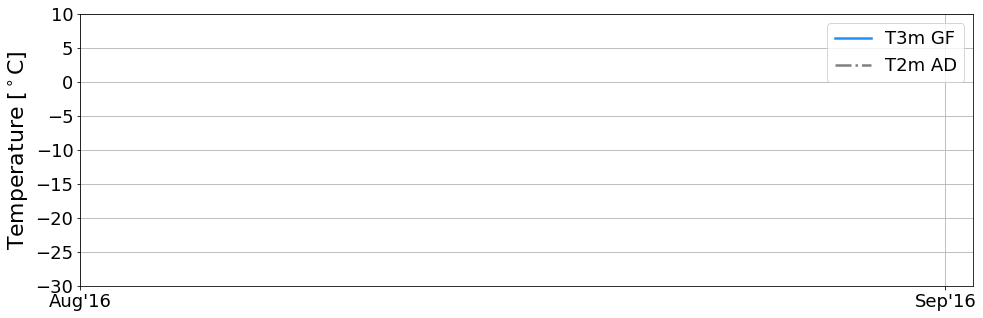

In [26]:
f9, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize = (16,5))
# maxGF = max(GF_data.T3m_minutt_Avg)
# date_maxGF = GF_data.T3m_minutt_Avg.idxmax()
# date_minGF = GF_data.T3m_minutt_Avg.idxmin()
# print(date_maxGF,date_minGF)
# maxAVD = max(AVD_data.T2m_PT1000_Avg)
# date_maxAVD = AVD_data.T2m_PT1000_Avg.idxmax()
# date_minAVD = AVD_data.T2m_PT1000_Avg.idxmin()
# print(date_maxAVD,date_minAVD)


dTind = GF_data.index
xticks=[]
dates = ['2016-08-01 00:00:00','2016-09-01 00:00:00','2016-10-01 00:00:00','2016-11-01 00:00:00','2016-12-01 00:00:00',
        '2017-01-01 00:00:00','2017-02-01 00:00:00','2017-03-01 00:00:00','2017-04-01 00:00:00',]
for counter, value in enumerate(dTind):
    if str(value) in dates:
        xticks.append(counter)

ax1.grid()
data = pd.DataFrame.from_records({"date":GF_data.index.date,"GF":GF_data.T3m_minutt_Avg.tolist(),'AD':AVD_data.T2m_PT1000_Avg.tolist()})
ax1.plot(data.index, data.GF.rolling(24,center=True).mean(),color="#1E90FF",linestyle='-',linewidth=2.5, label = "T3m GF")
ax1.plot(data.index, data.AD.rolling(24,center=True).mean(),color ="#808080",linestyle='-.', linewidth=2.5, label = "T2m AD")
ax1.set_ylabel("Temperature [$^\circ$C]",fontsize =22)
ax1.set_ylim((-30,10))
ax1.yaxis.set_major_locator(plt.MaxNLocator(10))
ax1.set_yticks(np.arange(-30,11,5))
ax1.set_xlim((0,len(data.index)))
ax1.set_xticks(ticks=xticks)
ax1.set_xticklabels(['Aug\'16','Sep\'16','Oct\'16','Nov\'16','Dec\'16',
        'Jan\'17','Feb\'17','Mar\'17','Apr\'17'])
ax1.tick_params(labelsize=18)
ax1.legend(fontsize=18)
#TEST: Customize xticklabels, want to set them in the middle between majorticks.
# ax1.set_xticklabels('')
# ax1.set_xticks(ticks=xticks, minor = True)
# ax1.set_xticklabels(['Aug\'16','Sep\'16','Oct\'16','Nov\'16','Dec\'16',
#         'Jan\'17','Feb\'17','Mar\'17','Apr\'17'], minor = True)
# f9.autofmt_xdate()
plt.savefig('./figures/timel_T3mGF_T2mAD.png')
plt.savefig('./figures/timel_T3mGF_T2mAD.eps')

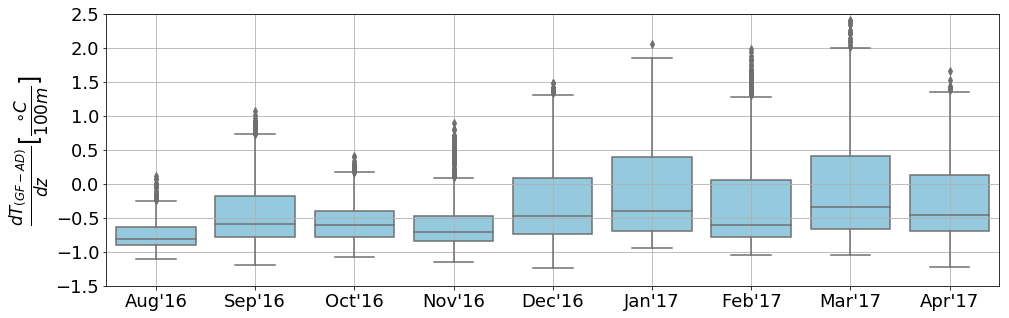

In [7]:
f9, (ax2) = plt.subplots(nrows = 1, ncols = 1, figsize = (16,5))
sns.boxplot(Tgrad_GFAVD_3m2mRot.index.strftime("%b\'%y"),Tgrad_GFAVD_3m2mRot,ax=ax2,
 color='skyblue', saturation=0.75)
ax2.set_ylabel(r'$\frac{dT_{(GF-AD)}}{dz} [\frac{\circ C}{100 m}]$', fontsize=24)
ax2.tick_params(labelsize=18)
ax2.set_ylim([-1.5,2.5])
ax2.yaxis.set_major_locator(plt.MaxNLocator(9))
# ax2.set_yticklabels([-1.5,-1.0,-0.5,0,0.5,1,1.5,2,2.5])
ax2.grid()

plt.savefig('./figures/Tgrad_boxpl_T3mGF_T2mAD.png')
plt.savefig('./figures/Tgrad_boxpl_T3mGF_T2mAD.eps')




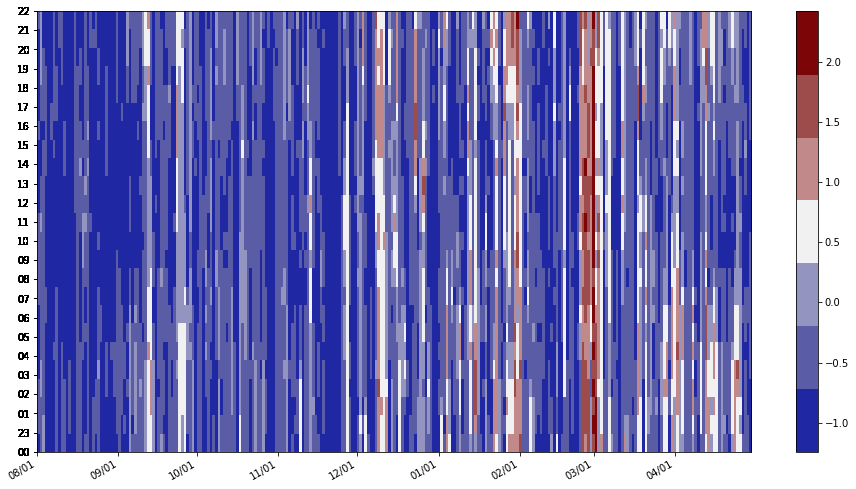

In [8]:
data = pd.DataFrame()
data['Date']=Tgrad_GFAVD_3m2mRot.index.date
data['Time']=Tgrad_GFAVD_3m2mRot.index.strftime("%H")
data['Tgrad']=Tgrad_GFAVD_3m2mRot.values
data["datenum"]=mdates.date2num(data["Date"])

C = data.pivot(index='Time', columns='Date', values='Tgrad')
# print(C.head())
fig, ax = plt.subplots(figsize = (16,9))
# cmap = colors.ListedColormap(["#1F28A2","#2C329F","#363A9E","#3E429E","#464A9F",
#                               "#4E51A2","#5659A4","#5E61A7","#6668AB","#6F70AE",
#                               "#7779B2","#8081B7","#898ABB","#9394C0","#9D9EC6",
#                               "#A7A8CB","#B3B4D1","#C0C0D8","#CECFDF","#E1E1E9",
#                               "#E9DFDF","#E1CBCB","#DABBBB","#D3ADAD","#CDA0A0",
#                               "#C79494","#C18989","#BB7F7F","#B67475","#B06B6B",
#                               "#AB6162","#A55858","#A04F4F","#9B4647","#953D3E",
#                               "#903435","#8B2B2C","#862122","#811617","#7C0607"])
# cmap = colors.ListedColormap(["#1F28A2","#363B9E","#474BA0","#585AA5","#686AAB",
#                               "#797BB4","#8C8DBD","#A0A1C8","#B8B9D4","#D6D6E3",
#                               "#E5D4D4","#D6B2B3","#C99899","#BD8282","#B26D6D",
#                               "#A65A5A","#9C4848","#913536","#862222","#7C0607"])
# cmap = colors.ListedColormap(["#1F28A2","#494CA0","#6C6EAD","#9394C0","#C4C5DA",
#                               "#DCC0C0","#C18989","#A95E5E","#923738","#7C0607"])
cmap = colors.ListedColormap(["#1F28A2","#5A5DA6","#9394C0","#F1F1F1","#C18989","#9D4B4B","#7C0607"])



pl = ax.imshow(C,aspect = 'auto',
               cmap = cmap,
               extent=[data["datenum"].iloc[0],data["datenum"].iloc[-1],data["Time"].iloc[0],data["Time"].iloc[-1]],
               origin = "lower")
ax.set_yticks(data["Time"])
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d") )
fig.autofmt_xdate()
plt.colorbar(pl)




count    6552.000000
mean        6.607194
std         3.710138
min         0.000000
25%         3.855000
50%         5.847000
75%         8.750000
max        26.980000
Name: ff2m_mps_Max, dtype: float64
count    6552.000000
mean        7.845146
std         4.229999
min         0.000000
25%         4.704000
50%         7.056000
75%        10.290000
max        32.050000
Name: ff10m_sek_Max, dtype: float64
count    6552.000000
mean        7.146599
std         4.721849
min         0.000000
25%         3.352000
50%         6.017000
75%        10.000000
max        28.620000
Name: ff_mps_Max, dtype: float64


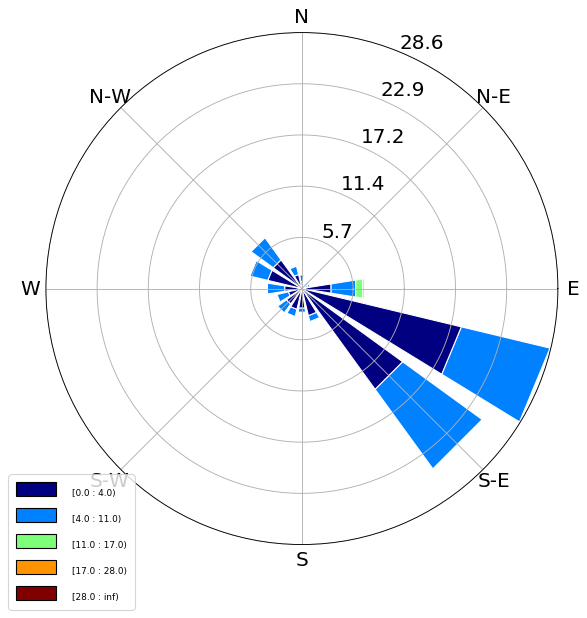

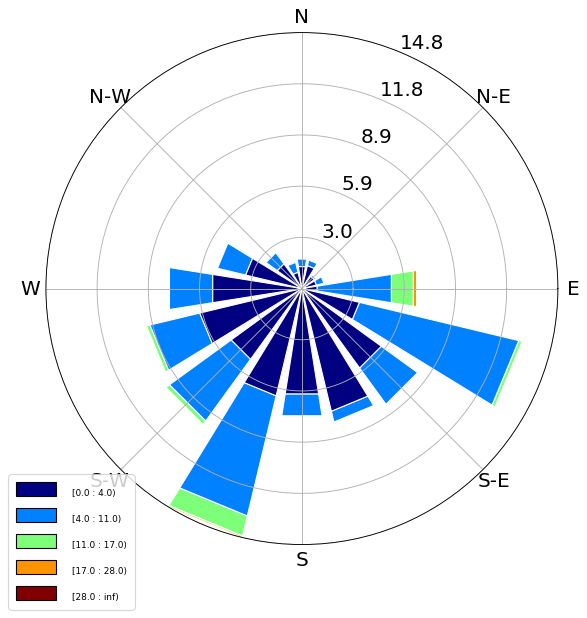

In [9]:
from windrose import WindroseAxes
# import matplotlib.cm as cm

# Set variables
ff10m_AD = AVD_data.ff10m_mps_Avg
ff2m_AD = AVD_data.ff2m_mps_avg
ff10mX_AD = AVD_data.ff10m_sek_Max
ff2mX_AD = AVD_data.ff2m_mps_Max
dd10m_AD = AVD_data.dd10m
dd2m_AD = AVD_data.dd2m

ff_GF = GF_data.ff_mps_avg
ffX_GF = GF_data.ff_mps_Max
dd_GF = GF_data.dd

print(ff2mX_AD.describe())
print(ff10mX_AD.describe())
print(ffX_GF.describe())
# print(ff_GF)
# print(dd_GF)

# ax1 = WindroseAxes.from_ax()
# ax1.bar(dd10m_AD, ff10m_AD, normed=True, opening=0.8, edgecolor='white', bins = [0,4,11,17])
# ax1.set_legend()

# fig,ax2 = plt.subplots(1,1)
ax2 = WindroseAxes.from_ax()
ax2.bar(dd2m_AD, ff2m_AD, normed=True, opening=0.8, edgecolor='white', bins = [0,4,11,17,28])
ax2.set_legend()
ax2.tick_params(labelsize=18)
ax2.set_legend(loc='center', bbox_to_anchor=(0.05, 0.005), fontsize = 18)
# ax2.savefig('./figures/windrose_AD2m.eps')
# fig.savefig('./figures/windrose_AD2m.png')
# fig.savefig('./figures/windrose.png')

# fig3,ax3 = plt.subplots()
ax3 = WindroseAxes.from_ax()
ax3.bar(dd_GF, ff_GF, normed=True, opening=0.8, edgecolor='white', bins = [0,4,11,17,28])
ax3.tick_params(labelsize=18)
ax3.set_legend(loc='center', bbox_to_anchor=(0.05, 0.005), fontsize = 18)
# fig3.savefig('./figures/windrose_GF.eps')
# fig2.savefig('./figures/windrose_GF.png')

NameError: name 'albedo' is not defined

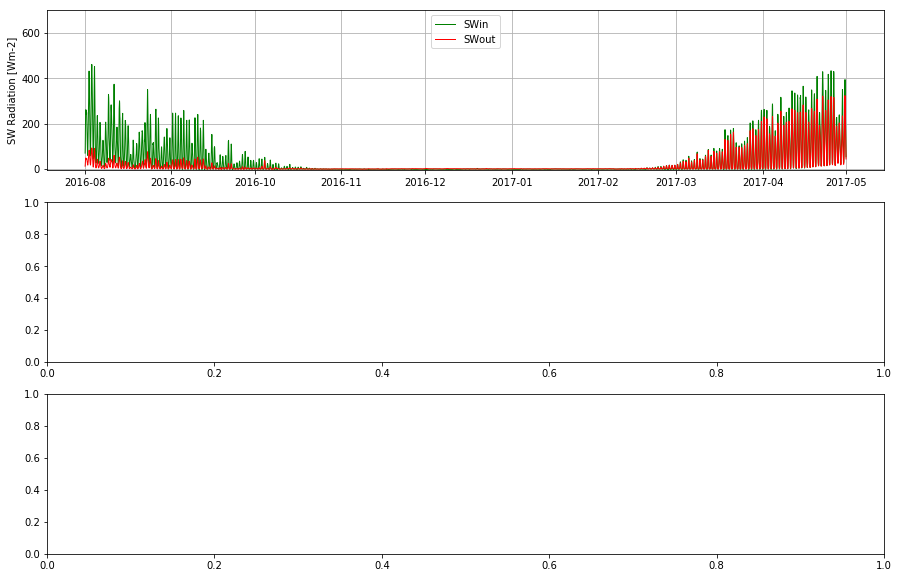

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols=1, figsize= (15,10))
ax1.plot(AVD_rad_data.index, AVD_rad_data.SWin_Wpm2.rolling(6,center=True).mean(), color = 'g', linewidth = 1, label = 'SWin')
ax1.plot(AVD_rad_data.index, AVD_rad_data.SWout_Wpm2.rolling(6,center=True).mean(), color = 'r', linewidth = 1, label = 'SWout')
ax1.set_ylim(-5,700)
ax1.grid()
ax1.set_ylabel('SW Radiation [Wm-2]')
ax1.legend(loc = 'upper center')

# albedo = AVD_rad_data.SWout_Wpm2/AVD_rad_data.SWin_Wpm2

for i in range(0, len(AVD_rad_data.index)):
	if np.logical_or(albedo[i]>1,albedo[i]<0):
		albedo[i] = np.NaN 

ax2.plot(AVD_rad_data.index,albedo.rolling(6,center=True).mean(),color = 'k', linewidth = 1, label = 'Albedo')
ax2.set_ylim(0,1)
ax2.grid()
ax2.set_ylabel('Albedo')
ax2.legend(loc = 'upper center')

ax3.plot(AVD_rad_data.index, AVD_rad_data.LWin_Wpm2.rolling(6,center=True).mean(), color = 'g', linewidth = 1, label = 'LWin')
ax3.plot(AVD_rad_data.index, AVD_rad_data.LWout_Wpm2.rolling(6,center=True).mean(), color = 'r', linewidth = 1, label = 'LWout')
# ax1.set_ylim(-5,700)
ax3.grid()
ax3.set_ylabel('LW Radiation [Wm-2]')
ax3.legend(loc = 'upper center')

fig.savefig('./figures/radiation.eps')
fig.savefig('./figures/radiation.png')